In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, plot_roc_curve, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, StratifiedKFold
from yellowbrick.model_selection import LearningCurve
from sklearn.pipeline import Pipeline

In [56]:
game_stats=pd.read_csv('game_stats_results.csv')
nlp=pd.read_csv('nlp_results.csv')

In [57]:
columns=['home_team','away_team','final_result','predict_stats','proba_stats_home','proba_stats_draw','proba_stats_away']
game_stats=game_stats.loc[:,columns]

In [58]:
game_stats.head(1)

,home_team,away_team,final_result,predict_stats,proba_stats_home,proba_stats_draw,proba_stats_away
0,Hertha Berlin,Hoffenheim,Away,-1,0.04097,0.120401,0.838629


In [59]:
columns=['team_home','team_away','result','proba_home','proba_draw','proba_away']
nlp=nlp.loc[:,columns]

In [60]:
nlp.head(1)

,team_home,team_away,result,proba_home,proba_draw,proba_away
0,FC Koln,Freiburg,Away,0.500788,0.119366,0.379846


In [61]:
def get_stats(row,column):
    home = row['team_home']
    away = row['team_away']
    df=game_stats.query(f'(home_team == "{home}") & (away_team == "{away}")')
    if len(df)==0:
        return np.nan
    else:
        return df[column].values[0]

In [294]:
df=nlp
columns=['proba_stats_home', 'proba_stats_draw', 'proba_stats_away']
for column in columns:
    df[column]=df.apply(lambda row: get_stats(row,column), axis=1)
df=df.dropna()


# Draw Exploratory

In [313]:
X_proba=df[['proba_draw','proba_stats_draw','result']]
X_proba.result=X_proba.result.apply(lambda x: 1 if x == 'Draw' else 0)

In [314]:
X_proba.proba_draw_label=pd.qcut(X_proba.proba_draw,4, labels=range(4,0,-1))
X_proba.proba_stats_draw_label=pd.qcut(X_proba.proba_stats_draw,4, labels=range(4,0,-1))

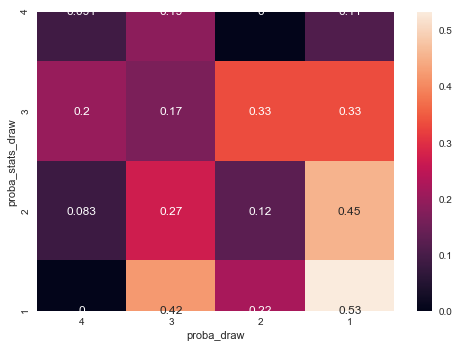

In [315]:
x=pd.crosstab(index=X_proba.proba_stats_draw_label, columns=X_proba.proba_draw_label, values=X_proba.result, aggfunc='mean')
sns.heatmap(x, annot=True)

# Draw Modeling

In [327]:
X = X_proba.drop('result', axis=1)
y = X_proba['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [328]:
param_grid = {'max_depth': [1, 5, 10 , 15, 20],
              'criterion': ['gini', 'entropy'],
              'splitter': ['random', 'best'],
              'min_samples_split': [2, 4, 6, 8, 10, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]}

In [329]:
gsearch = GridSearchCV(estimator=model_draw, param_grid=param_grid, n_jobs=-1, cv=3)

In [330]:
model_draw = gsearch.fit(X_train, y_train)

In [331]:
# Best params by the best score

print(model_draw.best_params_, model_draw.best_score_)

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 20, 'splitter': 'random'} 0.782051282051282


In [333]:
model_draw = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=20, min_samples_leaf=10, min_samples_split=20)

In [334]:
pipe_draw = Pipeline(steps=[('model', model_draw)])

In [335]:
pipe_draw.fit(X_train, y_train)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(max_depth=20, min_samples_leaf=10,
                                        min_samples_split=20,
                                        splitter='random'))])

In [336]:
pipe_draw.score(X_test, y_test)

0.8205128205128205

In [337]:
precision_score(y_test, pipe_draw.predict(X_test), average='weighted')

0.6732412886259039

In [338]:
results = cross_val_score(pipe_draw, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='roc_auc_ovr')
(np.mean(results), np.std(results))

(0.5925, 0.261325414420837)

# Home Exploratory

In [252]:
X_proba=df[['proba_home','proba_stats_home','result']]

In [253]:
X_proba.result=X_proba.result.apply(lambda x: 1 if x == 'Home' else 0)

In [254]:
X_proba.proba_home_label=pd.qcut(X_proba.proba_home,4, labels=range(4,0,-1))
X_proba.proba_stats_home_label=pd.qcut(X_proba.proba_stats_home,4, labels=range(4,0,-1))

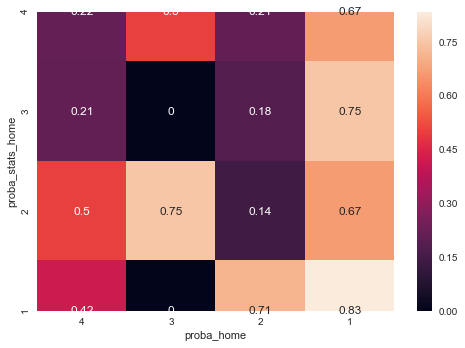

In [255]:
x=pd.crosstab(index=X_proba.proba_stats_home_label, columns=X_proba.proba_home_label, values=X_proba.result, aggfunc='mean')
sns.heatmap(x, annot=True)

# Home Modeling

In [281]:
X = X_proba.drop('result', axis=1)
y = X_proba['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [282]:
param_grid = {'max_depth': [1, 5, 10 , 15, 20],
              'criterion': ['gini', 'entropy'],
              'splitter': ['random', 'best'],
              'min_samples_split': [2, 4, 6, 8, 10, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]}

In [283]:
model_home = DecisionTreeClassifier()

In [284]:
gsearch = GridSearchCV(estimator=model_home, param_grid=param_grid, n_jobs=-1, cv=3)
model = gsearch.fit(X_train, y_train)
# Best params by the best score

print(model.best_params_, model.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 8, 'splitter': 'random'} 0.717948717948718


In [285]:
model_home = DecisionTreeClassifier(criterion='gini', splitter='random', max_depth=10, min_samples_leaf=5, min_samples_split=20)

In [286]:
pipe_home = Pipeline(steps=[('model', model_home)])

In [287]:
pipe_home.fit(X_train, y_train)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(max_depth=10, min_samples_leaf=5,
                                        min_samples_split=20,
                                        splitter='random'))])

In [288]:
pipe_home.score(X_test, y_test)

0.6666666666666666

In [290]:
precision_score(y_test, pipe_home.predict(X_test), average='weighted')

0.6397849462365591

In [291]:
results = cross_val_score(pipe_home, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='roc_auc_ovr')
(np.mean(results), np.std(results))

(0.5816666666666667, 0.20033998879682288)

# Away Swap-In

In [339]:
X_proba=df[['proba_away','proba_stats_away','result']]

In [340]:
X_proba.result=X_proba.result.apply(lambda x: 1 if x == 'Away' else 0)

In [341]:
X_proba.proba_away_label=pd.qcut(X_proba.proba_away,4, labels=range(4,0,-1))
X_proba.proba_stats_away_label=pd.qcut(X_proba.proba_stats_away,4, labels=range(4,0,-1))

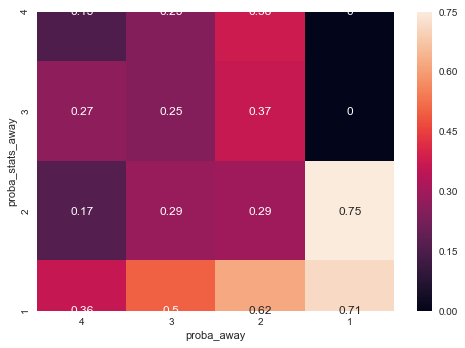

In [342]:
x=pd.crosstab(index=X_proba.proba_stats_away_label, columns=X_proba.proba_away_label, values=X_proba.result, aggfunc='mean')
sns.heatmap(x, annot=True)

# Away Modeling

In [343]:
X = X_proba.drop('result', axis=1)
y = X_proba['result']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

In [344]:
param_grid = {'max_depth': [1, 5, 10 , 15, 20],
              'criterion': ['gini', 'entropy'],
              'splitter': ['random', 'best'],
              'min_samples_split': [2, 4, 6, 8, 10, 20],
              'min_samples_leaf': [1, 5, 10, 15, 20]}

In [355]:
model_away = DecisionTreeClassifier()

In [356]:
gsearch = GridSearchCV(estimator=model_away, param_grid=param_grid, n_jobs=-1, cv=3)
model = gsearch.fit(X_train, y_train)
# Best params by the best score

print(model.best_params_, model.best_score_)

{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 4, 'splitter': 'random'} 0.717948717948718


In [357]:
model_away = DecisionTreeClassifier(criterion='entropy', splitter='random', max_depth=15, min_samples_leaf=5, min_samples_split=4)

In [358]:
pipe_away = Pipeline(steps=[('model', model_away)])

In [359]:
pipe_away.fit(X_train, y_train)

Pipeline(steps=[('model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=15,
                                        min_samples_leaf=5, min_samples_split=4,
                                        splitter='random'))])

In [360]:
pipe_away.score(X_test, y_test)

0.6666666666666666

In [361]:
precision_score(y_test, pipe_away.predict(X_test), average='weighted')

0.6238095238095238

In [363]:
results = cross_val_score(pipe_away, X_train, y_train, cv=StratifiedKFold(n_splits=20), scoring='roc_auc_ovr')
(np.mean(results), np.std(results))

(0.6041666666666666, 0.25450796756792426)